In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Predicting NBA 2021-22 MVP**

##      **I. Data preprocessing**

In [264]:
unusefull_columns = [
    'Team',
    'G',             
    'GS',               #Game started, partialy filled
    'FG',               #Sum of 2P and 3P
    'FGA',              #Sum of 2PA and 3PA
    'FG%',              #Depending of 2P% and 3P%
    '2PA',              #Depending of 2P and 2P%
    '3PA',              #Depending of 3P and 3P%
    'FTA',              #Depending of FT and FT%
    'TRB',              #Sum of ORB and DRB
    'Decade',           #Unusefull
    'Trade',            #Filled by False, only players that haven't been
                        #traded during the season can pretend to the award
    'MPTot',            #Depending of number of match during the season
    'W',                #Idem
    'L'                 #Idem
]

In [265]:
#Numeric types of columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']

In [266]:
#Imports
dataset = pd.read_csv('global.csv').drop(columns=unusefull_columns)

data_22 = pd.read_csv('2022.csv').drop(columns = [col for col in unusefull_columns if col in pd.read_csv('2022.csv').columns])

In [267]:
Pos = []
for pos in dataset.Pos.values :
    Pos.append(pos.split("-")[0])

dataset.Pos = Pos

In [268]:
''''Dealing with columns dtypes'''

col_cat = ['Pos', 'Season', 'Player','Tm']

col_int = ['Age', 'GB', 'GBC', 'Ranking_Conf', 'Ranking_League','ShareYN', 'Playoffs', 'MVP','PastMVP']

for column in dataset.columns :
    if column not in col_cat and column not in col_int :
        dataset[column] = dataset[column].astype(float)
    elif column in col_int :
        dataset[column] = dataset[column].astype(int)

### ***1. Scaling of numerical features***

#### **a. Historical seasons dataset**

The aim is to compared each MVP races. So we have to adapt our scaling method and scaled every season regardless from the other. (scaling one season after another)

In [269]:
'''Scaling'''

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

#Float columns
float_columns = ['float16', 'float32', 'float64']

#Columns to scale
columns_scale = list(dataset.select_dtypes(include=float_columns).columns)

#This is the only float column type that we don't want to scale
columns_scale.remove('MVP_share')

def season_scaler(df, season) :
    
    df_season = df[df.Season == season]
    for column in columns_scale :
        data = np.transpose(np.array([df_season[column].values]))
        scaled_data = sc.fit_transform(data)
        df_season[column] = list(scaled_data.transpose()[0])

    return df_season

In [270]:
'''2nd part of scaling'''

#Empty dataset that is going to be filled by scaled 'seasons'
dataset_scaled = pd.DataFrame(columns=dataset.columns)

#Looping through seasons
for season in set(dataset.Season.values) :

    #Adding season scaled dataset to global scaled dtaset
    dataset_scaled = dataset_scaled.append(season_scaler(dataset, season), ignore_index=True)

/var/folders/k3/3tz5rmjd3j3fsyyg9ynxk2680000gn/T/ipykernel_10749/4120735483.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season[column] = list(scaled_data.transpose()[0])
/var/folders/k3/3tz5rmjd3j3fsyyg9ynxk2680000gn/T/ipykernel_10749/4120735483.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season[column] = list(scaled_data.transpose()[0])
/var/folders/k3/3tz5rmjd3j3fsyyg9ynxk2680000gn/T/ipykernel_10749/4120735483.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of

#### **b. 2021-2022 dataset**

In [271]:
data_22_scaled = season_scaler(data_22, '2021-2022')

### ***2. Encoding the column `Pos` (postion played by the player)***

#### **a. Historical seasons dataset**

In [272]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['Pos'])] , remainder='passthrough')

dataset_scaled  = ct.fit_transform(dataset_scaled)

l = ct.get_feature_names_out(input_features=None)

l = [elt.split("__")[1] for elt in l]

In [273]:
dataset_scaled = pd.DataFrame(dataset_scaled)

In [274]:
dic_columns = {}

for col in dataset_scaled.columns :
    dic_columns[col] = l[int(col)]

In [275]:
dataset_scaled.rename(columns = dic_columns, inplace = True)

In [276]:
dataset_scaled.drop(columns = ['Pos_C'], inplace = True)

#### **b. 2021-2022 dataset**

In [277]:
data_22_scaled = ct.fit_transform(data_22_scaled)

l = ct.get_feature_names_out(input_features=None)

l = [elt.split("__")[1] for elt in l]

In [278]:
data_22_scaled = pd.DataFrame(data_22_scaled)

In [279]:
dic_columns = {}

for col in data_22_scaled.columns :
    dic_columns[col] = l[int(col)]

In [280]:
data_22_scaled.rename(columns = dic_columns, inplace = True)

In [281]:
data_22_scaled.drop(columns = ['Pos_C'], inplace = True)

##      **II. Predicting the eligibility**

Our first problem is a classification problem: **Will the player receive votes or not?** (label `ShareYN`)

In [282]:
data_classif = dataset_scaled.drop(columns=['MVP', 'MVP_share'])

#We create a copy of our global dataset without the columns MVP (boolean column) and MVP_share (share of votes that the player received)

### ***1. Dimension dowsizing***

##### **a. Separation between features and labels**

In [283]:
Player_c = data_classif[['Player', 'Season','Tm']]
X_c = data_classif.drop(columns=['Player', 'Season','Tm','ShareYN'])
y_c = data_classif.ShareYN

In [284]:
X_train_c = X_c.sample(frac=0.8).sort_index()
X_test_c = X_c.drop(X_train_c.index).sort_index()

Player_train_c = Player_c.iloc[list(X_train_c.index),:].sort_index()
Player_test_c = Player_c.drop(X_train_c.index).sort_index()

y_train_c = y_c[X_train_c.index].sort_index()
y_test_c = y_c.drop(X_train_c.index).sort_index()

#### **b. Puting the data in the right format**

In [285]:
for col in list(X_train_c.columns)[:5] :
    X_train_c[col] = X_train_c[col].astype(bool)
    X_test_c[col] = X_test_c[col].astype(bool)

In [286]:
y_train_c = y_train_c.astype(bool)
y_test_c = y_test_c.astype(bool)

#### **c. Cross Validation**

##### *1. First naive method*

For our cross validation we choose a Ridge classifier and we have made vary the `alpha` coefficient.

In [287]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

clf_ridge = linear_model.RidgeClassifier()

clf_unblced = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])})

clf_unblced.fit(X_train_c.fillna(0), y_train_c)

clf_unblced.cv_results_

{'mean_fit_time': array([0.05330663, 0.04822507, 0.04645967]),
 'std_fit_time': array([0.00705108, 0.00126592, 0.00036032]),
 'mean_score_time': array([0.01285257, 0.01268878, 0.01310377]),
 'std_score_time': array([0.0006391 , 0.00040552, 0.0016019 ]),
 'param_alpha': masked_array(data=[0.01, 1.0, 10.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 1.0}, {'alpha': 10.0}],
 'split0_test_score': array([0.97819191, 0.97819191, 0.97858842]),
 'split1_test_score': array([0.96986519, 0.96946868, 0.96907216]),
 'split2_test_score': array([0.9742268 , 0.9742268 , 0.97383029]),
 'split3_test_score': array([0.9742268 , 0.9742268 , 0.97462331]),
 'split4_test_score': array([0.97501983, 0.97501983, 0.97462331]),
 'mean_test_score': array([0.97430611, 0.9742268 , 0.9741475 ]),
 'std_test_score': array([0.00265869, 0.00279252, 0.00303428]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

We see that whatever the value of the alpha parameter, our predictor obtains the same score.

In [288]:
y_train_c.value_counts()

False    12061
True       549
Name: ShareYN, dtype: int64

After this test we see that our dataset is unbalanced. Indeed there is a ratio higher than 20 between the two labels. So we have to balance our dataset.

##### *2. Dealing with unbalanced dataset*

To tackle the unbalanced dataset issue, we will use an oversampling method.

In [289]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy ='minority')

In [290]:
X_over_c, y_over_c = oversample.fit_resample(X_train_c, y_train_c)

In [291]:
from sklearn.metrics import make_scorer, recall_score

scoring = True

scorer_c = make_scorer(recall_score)

if scoring :
    clf_over = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])}, scoring=scorer_c)
else :
    clf_over = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])})

clf_over.fit(X_over_c.fillna(0), y_over_c)

clf_over.cv_results_

{'mean_fit_time': array([0.09873619, 0.09685707, 0.09708929]),
 'std_fit_time': array([0.00431656, 0.00218981, 0.00189823]),
 'mean_score_time': array([0.02071981, 0.0203156 , 0.020152  ]),
 'std_score_time': array([0.00134871, 0.00093337, 0.00055733]),
 'param_alpha': masked_array(data=[0.01, 1.0, 10.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 1.0}, {'alpha': 10.0}],
 'split0_test_score': array([0.96766169, 0.96766169, 0.96766169]),
 'split1_test_score': array([0.9697472, 0.9697472, 0.9697472]),
 'split2_test_score': array([0.96310116, 0.96310116, 0.96393035]),
 'split3_test_score': array([0.95024876, 0.95024876, 0.95149254]),
 'split4_test_score': array([0.9606136 , 0.9606136 , 0.96227197]),
 'mean_test_score': array([0.96227448, 0.96227448, 0.96302075]),
 'std_test_score': array([0.0068253 , 0.0068253 , 0.00634147]),
 'rank_test_score': array([2, 2, 1], dtype=int32)}

In [292]:
clf_over.best_estimator_

RidgeClassifier(alpha=10.0)

#### **d. Extract important features**

After this CV, we extract the coefficients of the most important features.

In [293]:
features_coefs = np.transpose(np.vstack((X_over_c.columns, np.abs(clf_over.best_estimator_.coef_))))

features_coefs = pd.DataFrame(features_coefs, columns = ['feature', 'coef']).sort_values('coef', ascending = False, ignore_index = True)

<AxesSubplot:xlabel='coef', ylabel='feature'>

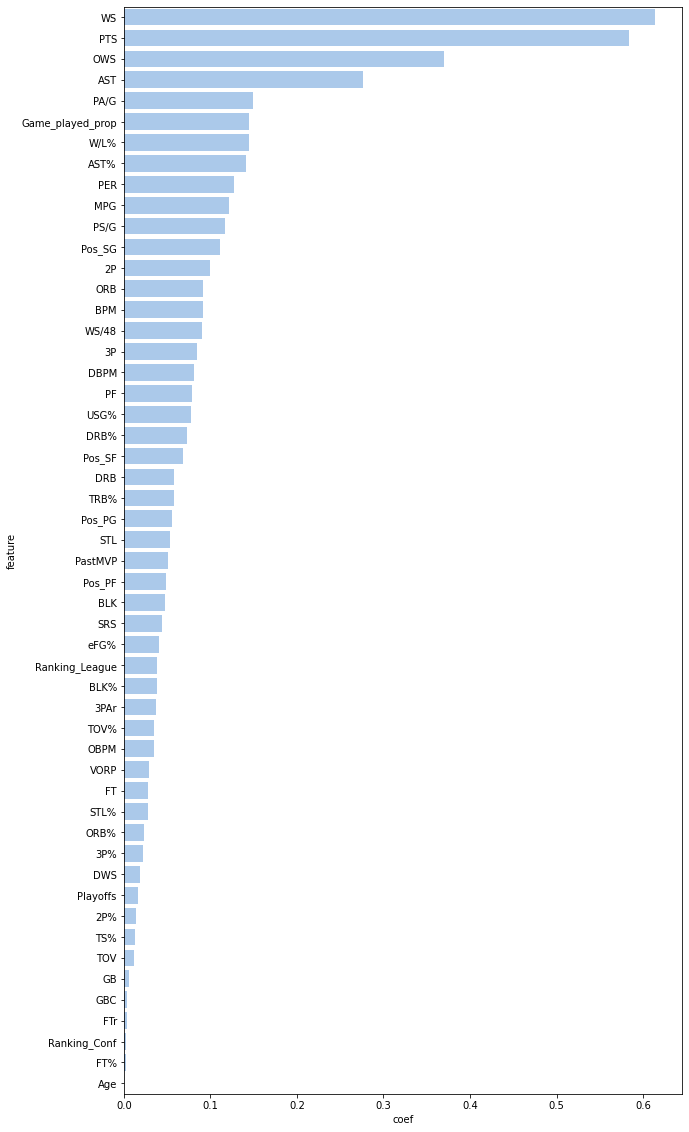

In [294]:
plt.figure(figsize = (10,20))

sns.set_color_codes("pastel")
sns.barplot(y=features_coefs.feature, x=features_coefs.coef, color="b")


In this histogram we have the features having the most impact on the prediction. We decide to take only the 15 most important ones.

In [304]:
features = features_coefs.feature.values[:15]

In [305]:
features

array(['WS', 'PTS', 'OWS', 'AST', 'PA/G', 'Game_played_prop', 'W/L%',
       'AST%', 'PER', 'MPG', 'PS/G', 'Pos_SG', '2P', 'ORB', 'BPM'],
      dtype=object)

### ***2. Machine learning model for our classification***

Let's get back our balanced training datasets.

Our features are given by this list :

In [306]:
features

array(['WS', 'PTS', 'OWS', 'AST', 'PA/G', 'Game_played_prop', 'W/L%',
       'AST%', 'PER', 'MPG', 'PS/G', 'Pos_SG', '2P', 'ORB', 'BPM'],
      dtype=object)

Let's make our balanced train reduced to our selected features features.

In [307]:
X_train_classifier = X_over_c[features].fillna(0)
y_train_classifier = y_over_c

We will make our classification with a `RidgeClassifier`. (alpha = 10)

#### **a. Training and performances of the model**

In [308]:
classifier = linear_model.RidgeClassifier(alpha=10)

In [309]:
y_train_classifier

0        False
1        False
2        False
3        False
4        False
         ...  
24117     True
24118     True
24119     True
24120     True
24121     True
Name: ShareYN, Length: 24122, dtype: bool

In [310]:
X_train_classifier

,WS,PTS,OWS,AST,PA/G,Game_played_prop,W/L%,AST%,PER,MPG,PS/G,Pos_SG,2P,ORB,BPM
0,-0.368005,-0.790574,-0.436091,-0.579086,0.025545,0.734162,1.633833,-0.704009,-0.753705,-0.478211,1.833235,True,-0.792862,-0.580894,-0.016326
1,1.359556,-0.197613,1.008084,-0.638234,0.025545,0.968868,1.633833,-0.942298,0.934400,0.069952,1.833235,False,-0.027976,1.050679,0.966825
2,-0.822627,-1.136468,-0.648470,-0.815677,0.025545,-1.534659,1.633833,-0.801491,-0.834864,-1.205945,1.833235,False,-1.098817,-0.580894,-0.061015
3,1.147400,1.877752,1.177987,0.722162,0.025545,0.499457,1.633833,-0.054130,0.820778,1.667186,1.833235,False,1.552789,0.674162,0.765726
4,0.874627,0.230637,0.965608,-0.579086,0.025545,0.499457,1.633833,-0.866479,0.642228,0.249523,1.833235,False,0.328971,0.925174,0.519938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24117,2.559519,2.433874,2.844636,1.915365,-0.705747,1.118032,1.478191,1.313821,0.884614,1.513899,1.453869,True,2.646217,-0.102500,0.322666
24118,1.261612,1.400861,0.563233,0.981900,-1.225924,0.768851,1.277410,0.310313,0.540951,1.444022,-0.169950,True,1.185862,0.766291,0.835742
24119,3.983836,2.894298,3.873860,0.745426,-0.039748,0.929454,1.396491,0.168369,1.970238,1.702943,1.365539,False,2.385173,0.157035,1.781476
24120,2.213872,0.912795,1.586891,3.810525,-1.147797,0.923734,1.104518,2.589009,1.050833,1.451704,-0.046913,False,0.526027,0.204113,1.553260


In [311]:
classifier.fit(X_train_classifier, y_train_classifier)

RidgeClassifier(alpha=10)

In [312]:
classifier.score(X_test_c[features].fillna(0), y_test_c)

0.9165873771011734

In [313]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_c,classifier.predict(X_test_c[features].fillna(0)))

array([[2765,  258],
       [   5,  125]])

In [314]:
y_test_c.value_counts()

False    3023
True      130
Name: ShareYN, dtype: int64

#### **b. Extraction of our 2021-2022 canditates**

##### *1. Splitting dataset*

In [315]:
Player_22 = data_22_scaled[['Player']]

X_22_classif = data_22_scaled.drop(columns=['Player', 'Season','Tm'])

In [316]:
X_22_classif = pd.DataFrame(X_22_classif)

In [317]:
for col in list(X_22_classif.columns)[:5] :
    X_22_classif[col] = X_22_classif[col].astype(bool)

In [318]:
X_22_classif = X_22_classif[features].fillna(0)

##### *2. Prediction of our candidates*

In [319]:
y_pred_22 = classifier.predict(X_22_classif)

In [320]:
results_22 = Player_22.assign(Prediction = y_pred_22)

results_22['coefs'] = classifier.decision_function(X_22_classif)


In [321]:
results_22[results_22.Prediction].sort_values('coefs', ascending = False, ignore_index = True)

,Player,Prediction,coefs
0,Nikola Jokić,True,1.541973
1,Giannis Antetokounmpo,True,1.466557
2,Joel Embiid,True,1.286436
3,Stephen Curry,True,1.194691
4,Chris Paul,True,1.176209
...,...,...,...
59,Jordan Poole,True,0.076570
60,Bobby Portis,True,0.034604
61,OG Anunoby,True,0.029135
62,Tyler Herro,True,0.019889


In [322]:
candidates = results_22.sort_values('coefs',ascending = False).Player.values[:20]

In [323]:
candidates

array(['Nikola Jokić', 'Giannis Antetokounmpo', 'Joel Embiid',
       'Stephen Curry', 'Chris Paul', 'LeBron James', 'James Harden',
       'Ja Morant', 'Luka Dončić', 'Kevin Durant', 'Jimmy Butler',
       'Devin Booker', 'DeMar DeRozan', 'Trae Young',
       'Karl-Anthony Towns', 'Jayson Tatum', 'LaMelo Ball',
       'Dejounte Murray', 'Anthony Davis', 'Darius Garland'], dtype=object)

In [324]:
len(candidates)

20

##      **III. Predicting the 2021-2022 NBA MVP**

Our second and last problem is a regression problem: **How many votes the player will receive?** (label `MVP_share`)

In [325]:
data_reg = dataset_scaled[dataset_scaled.ShareYN == 1].drop(columns=['MVP', 'ShareYN']).reset_index()

#We create a copy of our global dataset (only with players that received votes)
#without the columns MVP and ShareYN (0/1 columns)

###      ***1. Creating 2021-2022 dataset with candidates***

In [326]:
data_22_reg = data_22_scaled[data_22_scaled.Player.isin(candidates)]

data_22_reg = data_22_reg.reset_index()

In [327]:
Player_22_reg = data_22_reg[['Player']]

X_22_reg = data_22_reg[features]

###      ***2. Splitting, formating***

#### **a. Splitting**

In [328]:
Player_reg = data_reg[['Player', 'Season','Tm']]
X_reg = data_reg.drop(columns=['Player', 'Season','Tm','MVP_share'])
y_reg = data_reg.MVP_share

In [329]:
X_train_reg = X_reg.sample(frac=0.8).sort_index()
X_test_reg = X_reg.drop(X_train_reg.index).sort_index()

Player_train_reg = Player_reg.iloc[list(X_train_reg.index),:].sort_index()
Player_test_reg = Player_reg.drop(X_train_reg.index).sort_index()

y_train_reg = y_reg[X_train_reg.index].sort_index()
y_test_reg = y_reg.drop(X_train_reg.index).sort_index()

#### **b. Puting the data in the right format**

In [330]:
X_train_reg = pd.DataFrame(X_train_reg)
X_test_reg = pd.DataFrame(X_test_reg)

In [331]:
y_train_reg = y_train_reg.astype(float)
y_test_reg = y_test_reg.astype(float)

###      ***3. Dimension downsizing***

We will use the same features that we used to determine the candidates, these are stocked in the `features`.

In [332]:
X_train_reg = X_train_reg[features].fillna(0)
X_test_reg = X_test_reg[features].fillna(0)

###      ***4. Machine learning models for our regression***

To predict the MVP award winner, we will use differents algorithms and synthesize them in the report. Thus we will use :
- Linear regression
- Random Forest
- kNN
- Deep Neural Networks

#### **a. Linear regression**

##### *1. Training and performances*

In [333]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()

reg_lin.fit(X_train_reg, y_train_reg)

LinearRegression()

In [334]:
reg_lin.score(X_test_reg, y_test_reg)

0.3624803747933426

##### *2. Prediction for 2021-2022 season*

In [335]:
y_pred_22_lin = reg_lin.predict(X_22_reg)

In [336]:
results_22_lin = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_lin)).transpose(), columns = ['player', 'share_pred'])

In [337]:
results_22_lin.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,13,Nikola Jokić,0.557902
1,4,Giannis Antetokounmpo,0.503256
2,9,Chris Paul,0.418184
3,14,Joel Embiid,0.411536
4,17,Stephen Curry,0.35204
5,1,Jimmy Butler,0.247196
6,7,LeBron James,0.245577
7,2,Kevin Durant,0.240042
8,0,Ja Morant,0.226764
9,8,Devin Booker,0.21785


#### **b. Random Forest**

##### *1. Training and performances*

In [338]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

reg_rf = RandomForestRegressor()

param_rf = {
                'max_depth' : np.array([5, 10, 15]),
            }

reg_rf_CV = GridSearchCV(reg_rf, param_rf)

reg_rf_CV.fit(X_train_reg, y_train_reg)

reg_rf_CV.cv_results_

{'mean_fit_time': array([0.22179928, 0.35555358, 0.33682809]),
 'std_fit_time': array([0.01654274, 0.05283944, 0.01701897]),
 'mean_score_time': array([0.00839777, 0.01034141, 0.01013794]),
 'std_score_time': array([0.00054576, 0.00336528, 0.00155867]),
 'param_max_depth': masked_array(data=[5, 10, 15],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5}, {'max_depth': 10}, {'max_depth': 15}],
 'split0_test_score': array([0.708572  , 0.70288273, 0.69757367]),
 'split1_test_score': array([0.57376961, 0.55445941, 0.57047988]),
 'split2_test_score': array([0.68366346, 0.70656598, 0.69501333]),
 'split3_test_score': array([0.67172881, 0.68689769, 0.7067525 ]),
 'split4_test_score': array([0.62356989, 0.64321379, 0.62131592]),
 'mean_test_score': array([0.65226075, 0.65880392, 0.65822706]),
 'std_test_score': array([0.04800025, 0.05682296, 0.05351281]),
 'rank_test_score': array([3, 1, 2], dtype=int32)}

In [339]:
reg_rf_best = reg_rf_CV.best_estimator_

reg_rf_best.score(X_test_reg, y_test_reg)

0.40996882583906935

##### *2. Prediction for 2021-2022 season*

In [340]:
y_pred_22_rf = reg_rf_best.predict(X_22_reg)

In [341]:
results_22_rf = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_rf)).transpose(), columns = ['player', 'share_pred'])

In [342]:
results_22_rf.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,13,Nikola Jokić,0.572215
1,4,Giannis Antetokounmpo,0.455149
2,9,Chris Paul,0.360506
3,17,Stephen Curry,0.195099
4,2,Kevin Durant,0.163366
5,7,LeBron James,0.157556
6,14,Joel Embiid,0.141239
7,11,DeMar DeRozan,0.111492
8,1,Jimmy Butler,0.087562
9,12,Trae Young,0.087559


#### **c. kNN**

##### *1. Training and performances*

In [343]:
from sklearn.neighbors import KNeighborsRegressor

reg_kNN = KNeighborsRegressor()

param_kNN = {
                'n_neighbors' : np.array([5, 10, 15, 20, 25]),
            }

reg_kNN_CV = GridSearchCV(reg_kNN, param_kNN)

reg_kNN_CV.fit(X_train_reg, y_train_reg)

reg_kNN_CV.cv_results_

{'mean_fit_time': array([0.00209737, 0.00171022, 0.00224538, 0.00165043, 0.00243745]),
 'std_fit_time': array([8.74652678e-04, 1.40830559e-04, 7.43752150e-04, 7.16603281e-05,
        6.70252758e-04]),
 'mean_score_time': array([0.0026792 , 0.00282192, 0.00323205, 0.00297637, 0.00404592]),
 'std_score_time': array([0.00032117, 0.00024319, 0.00045171, 0.00016655, 0.00044505]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25}],
 'split0_test_score': array([0.61790517, 0.62418916, 0.59768689, 0.61178565, 0.6157571 ]),
 'split1_test_score': array([0.55014267, 0.57827969, 0.56449418, 0.56211489, 0.55918435]),
 'split2_test_score': array([0.64193352, 0.65031452, 0.63948651, 0.60995891, 0.59192556]),
 'split3_test_score': array([0.62958385, 0.62045693, 0.

In [344]:
reg_kNN_best = reg_kNN_CV.best_estimator_

reg_kNN_best.score(X_test_reg, y_test_reg)

0.4731705027085973

##### *2. Prediction for 2021-2022 season*

In [345]:
y_pred_22_kNN = reg_kNN_best.predict(X_22_reg)

In [346]:
results_22_kNN = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_kNN)).transpose(), columns = ['player', 'share_pred'])

In [347]:
results_22_kNN.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,13,Nikola Jokić,0.7366
1,4,Giannis Antetokounmpo,0.5184
2,14,Joel Embiid,0.3097
3,9,Chris Paul,0.244
4,2,Kevin Durant,0.1639
5,7,LeBron James,0.1503
6,17,Stephen Curry,0.1474
7,11,DeMar DeRozan,0.1034
8,3,James Harden,0.0975
9,12,Trae Young,0.0945


#### **d. Deep Neural Network**

##### *1. Training and performances*

In [348]:
from sklearn.neural_network import MLPRegressor

reg_DNN = MLPRegressor()

param_DNN = {
                'hidden_layer_sizes' : np.array([50, 100, 200]),
                'activation' : np.array(['relu', 'logistic'])
            }

reg_DNN_CV = GridSearchCV(reg_DNN, param_DNN)

reg_DNN_CV.fit(X_train_reg, y_train_reg)

reg_DNN_CV.cv_results_

{'mean_fit_time': array([0.21093864, 0.28939309, 0.28867059, 0.08573093, 0.11554942,
        0.17615395]),
 'std_fit_time': array([0.02407424, 0.04622565, 0.10727905, 0.01320643, 0.02327082,
        0.03133114]),
 'mean_score_time': array([0.00198455, 0.00199504, 0.00198679, 0.00174618, 0.00220332,
        0.00217714]),
 'std_score_time': array([0.00073095, 0.00019517, 0.00063031, 0.0004015 , 0.00065248,
        0.00029924]),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'logistic', 'logistic',
                    'logistic'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'activation': 'relu', 'hidden_layer_sizes': 50},
  {'activation': 'relu', 'hidden_layer_sizes': 100},
  {'activation': 'relu', 'h

In [349]:
reg_DNN_best = reg_DNN_CV.best_estimator_

reg_DNN_best.score(X_test_reg, y_test_reg)

0.4525859083827415

##### *2. Prediction for 2021-2022 season*

In [350]:
y_pred_22_DNN = reg_DNN_best.predict(X_22_reg)

In [351]:
results_22_DNN = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_DNN)).transpose(), columns = ['player', 'share_pred'])

In [352]:
results_22_DNN.sort_values('share_pred', ascending = False)

,player,share_pred
13,Nikola Jokić,0.589882
4,Giannis Antetokounmpo,0.53152
14,Joel Embiid,0.456206
1,Jimmy Butler,0.313217
17,Stephen Curry,0.286074
8,Devin Booker,0.267872
9,Chris Paul,0.260239
11,DeMar DeRozan,0.175753
0,Ja Morant,0.152555
19,Luka Dončić,0.130535


##### *3. Bonus : Accuracy through history*

Dowsizing the number of features

In [353]:
dataset_bonus = dataset_scaled[dataset_scaled.ShareYN == 1]

In [354]:
seasons = list(set(dataset_bonus.Season.values))

seasons.sort()

Player_reg_bonus = dataset_bonus[['Player', 'Season']].reset_index()
X_reg_bonus = dataset_bonus.drop(columns=['Player', 'Season','Tm','MVP_share']).reset_index()
y_reg_bonus = dataset_bonus.MVP_share.reset_index()

L=[]
for season in seasons :
    l=[]
    l.append(season)
    l.append(dataset[(dataset.Season == season)&(dataset.MVP == 1)].Player.values[0])

    Player_test = Player_reg_bonus[Player_reg_bonus.Season == season]
    
    X_test = X_reg_bonus.iloc[list(Player_test.index),:].sort_index()
    y_test = y_reg_bonus.iloc[list(Player_test.index),:].sort_index()

    Player_train = Player_reg_bonus.drop(Player_test.index).sort_index()
    X_train = X_reg_bonus.drop(Player_test.index).sort_index()
    y_train = y_reg_bonus.drop(Player_test.index).sort_index()

    reg_DNN_best.fit(X_train[features].fillna(0), y_train['MVP_share'])

    y_pred = reg_DNN_best.predict(X_test[features].fillna(0))

    results = [list(Player_test.Player.values),list(y_pred)]

    results = np.array(results)

    results = pd.DataFrame(results.transpose(), columns = ['player', 'share_pred'])


    l.append(results[results.share_pred == max(list(results.share_pred.values))].player.values[0])
    L.append(l)

predictions = pd.DataFrame(L, columns = ['Season', 'Actual MVP', 'Predicted MVP'])

In [355]:
predictions

,Season,Actual MVP,Predicted MVP
0,1979-1980,Kareem Abdul-Jabbar,Julius Erving
1,1980-1981,Julius Erving,Julius Erving
2,1981-1982,Moses Malone,Moses Malone
3,1982-1983,Moses Malone,Larry Bird
4,1983-1984,Larry Bird,Larry Bird
5,1984-1985,Larry Bird,Larry Bird
6,1985-1986,Larry Bird,Larry Bird
7,1986-1987,Magic Johnson,Magic Johnson
8,1987-1988,Michael Jordan,Michael Jordan
9,1988-1989,Magic Johnson,Michael Jordan


In [356]:
predictions['ok'] = predictions['Actual MVP'] == predictions['Predicted MVP']

In [357]:
sum(predictions.ok.values)/len(predictions)

0.6904761904761905